# 久期：Python 实操 3

本讲内容包括：

1. 模块 7：交互式久期模拟（利率与价格动态关系）；
2. 模块 8：期限结构与凸性分析；
3. 模块 9：综合案例：久期管理策略比较。

本部分旨在帮助学生建立对利率变动与债券价格动态关系的直观理解。

## 模块 7. 交互式久期模拟

本节通过交互式滑块，动态演示利率变动下债券价格的非线性变化。
需要安装 `ipywidgets` 包 (`pip install ipywidgets`)。

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# 中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def bond_price(face, coupon_rate, ytm, maturity, freq=1):
    """计算债券价格"""
    periods = int(maturity * freq)
    coupon = face * coupon_rate / freq
    cashflows = np.repeat(coupon, periods)
    cashflows[-1] += face
    discount_factors = 1 / (1 + ytm/freq) ** np.arange(1, periods+1)
    return np.sum(cashflows * discount_factors)

def plot_price_curve(face=1000, coupon=0.05, maturity=5):
    """绘制固定坐标范围的债券价格-利率曲线"""
    # 每次绘图前新建画布，防止重复输出
    plt.figure(figsize=(5,3))
    
    rates = np.linspace(0.01, 0.10, 50)
    prices = [bond_price(face, coupon, y, maturity) for y in rates]
    
    plt.plot(rates*100, prices, color='blue', lw=2)
    plt.title(f'债券价格-利率曲线 (票息={coupon*100:.1f}%, 到期={maturity}年)')
    plt.xlabel('市场利率 (%)')
    plt.ylabel('债券价格 (元)')
    
    # 添加面值水平线
    plt.axhline(y=face, color='red', linestyle='--', lw=1.5, label='面值 (Face Value)')
    
    # 固定坐标范围
    plt.xlim(1, 10)
    plt.ylim(face * 0.8, face * 1.2)
    
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    #plt.show()

interact(plot_price_curve, face=(500,2000,100), coupon=(0.01,0.1,0.01), maturity=(1,10,1));


interactive(children=(IntSlider(value=1000, description='face', max=2000, min=500, step=100), FloatSlider(valu…

## 模块 8. 期限结构与凸性分析

久期提供一阶近似，而凸性 (Convexity) 反映价格曲线的弯曲程度。
两者结合可以更准确地估计债券价格变动：

$$ \nabla P / P \approx -D_{mod} \Delta y + 0.5 C (\Delta y)^2 $$

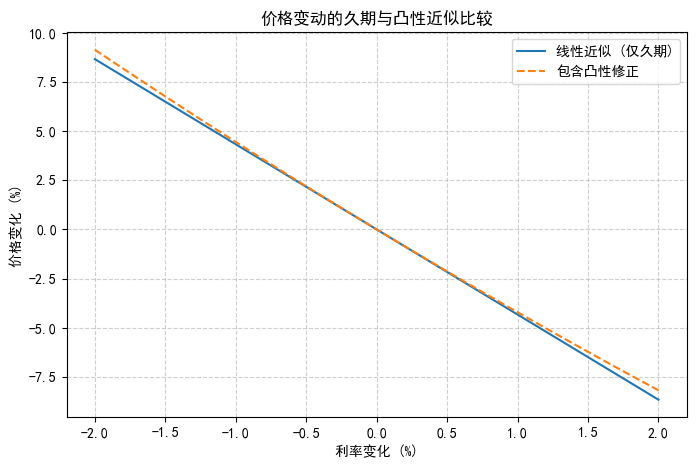

In [12]:
def convexity(face, coupon_rate, ytm, maturity, freq=1):
    periods = int(maturity * freq)
    coupon = face * coupon_rate / freq
    cashflows = np.repeat(coupon, periods)
    cashflows[-1] += face
    discount_factors = 1 / (1 + ytm/freq) ** np.arange(1, periods+1)
    pv_cf = cashflows * discount_factors
    time = np.arange(1, periods+1) / freq
    return np.sum(pv_cf * time * (time + 1/freq)) / (np.sum(pv_cf) * (1 + ytm/freq)**2)

face, coupon, ytm, maturity = 1000, 0.05, 0.05, 5
def macaulay_duration(face, coupon_rate, ytm, maturity, freq=1):
    periods = int(maturity * freq)
    coupon = face * coupon_rate / freq
    cashflows = np.repeat(coupon, periods)
    cashflows[-1] += face
    discount_factors = 1 / (1 + ytm/freq) ** np.arange(1, periods+1)
    pv_cashflows = cashflows * discount_factors
    weights = pv_cashflows / np.sum(pv_cashflows)
    time = np.arange(1, periods+1) / freq
    return np.sum(weights * time)

D_mod = macaulay_duration(face, coupon, ytm, maturity) / (1 + ytm)
C = convexity(face, coupon, ytm, maturity)
Δy = np.linspace(-0.02, 0.02, 41)
ΔP_lin = -D_mod * Δy
ΔP_quad = -D_mod * Δy + 0.5 * C * Δy**2
plt.figure(figsize=(8,5))
plt.plot(Δy*100, ΔP_lin*100, label='线性近似 (仅久期)')
plt.plot(Δy*100, ΔP_quad*100, label='包含凸性修正', linestyle='--')
plt.title('价格变动的久期与凸性近似比较')
plt.xlabel('利率变化 (%)')
plt.ylabel('价格变化 (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 模块 9. 综合案例：久期管理策略比较

我们比较三种久期管理策略在不同利率环境下的净值表现：
1. **被动策略**：固定久期 4 年；
2. **主动策略**：预判利率下降，提升久期至 8 年；
3. **免疫策略**：匹配负债久期 6 年，保持净值稳定。

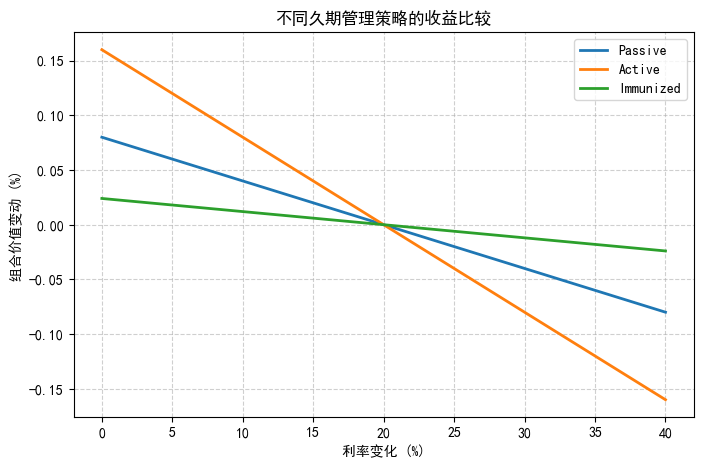

In [13]:
import pandas as pd
rate_changes = np.linspace(-0.02, 0.02, 41)
D_passive, D_active, D_immune = 4, 8, 6
returns = pd.DataFrame({
    'Passive': -D_passive * rate_changes,
    'Active': -D_active * rate_changes,
    'Immunized': -D_immune * rate_changes * 0.2  # 稳定型策略
})
returns.plot(figsize=(8,5), lw=2)
plt.title('不同久期管理策略的收益比较')
plt.xlabel('利率变化 (%)')
plt.ylabel('组合价值变动 (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()